In [23]:
from src.utility.config_loader import loader as config_loader
from src.utility.data_loader import  loader as data_loader
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 100)
sns.set_style("whitegrid")

from pathlib import Path

In [3]:
data_path = config_loader.load('data.yaml')['data']['raw_data_path']
data_path

'raw/MachineLearningRating_v3.txt'

In [4]:
df = data_loader.load_csv(data_path,sep='|')
df.shape

/home/ermias/Desktop/insurance/End-to-End_Insurance_Risk_Analytics_Predictive-Modeling/src/utility/data_loader.py:17: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path, **kwargs)


(1000098, 52)

In [5]:
df.isna().sum()

UnderwrittenCoverID               0
PolicyID                          0
TransactionMonth                  0
IsVATRegistered                   0
Citizenship                       0
LegalType                         0
Title                             0
Language                          0
Bank                         145961
AccountType                   40232
MaritalStatus                  8259
Gender                         9536
Country                           0
Province                          0
PostalCode                        0
MainCrestaZone                    0
SubCrestaZone                     0
ItemType                          0
mmcode                          552
VehicleType                     552
RegistrationYear                  0
make                            552
Model                           552
Cylinders                       552
cubiccapacity                   552
kilowatts                       552
bodytype                        552
NumberOfDoors               

In [7]:
df["TransactionMonth"] = pd.to_datetime(df["TransactionMonth"])
df["TransactionMonth"].dtype

dtype('<M8[ns]')

In [13]:
import pandas as pd

# Aggregate numeric and keep categorical first occurrence
policy_df = df.groupby("PolicyID", as_index=False).agg({
    "Province": "first",
    "PostalCode": "first",
    "Gender": "first",
    "TotalPremium": "sum",
    "TotalClaims": "sum"
})

# Verify
print(policy_df.shape)  # Expect ~7000 rows
policy_df.head(10)


(7000, 6)


,PolicyID,Province,PostalCode,Gender,TotalPremium,TotalClaims
0,14,Western Cape,7530,Male,915.785877,0.000000
1,15,Western Cape,7405,Female,151.867402,0.000000
2,16,Western Cape,7888,Male,0.000000,0.000000
3,17,Western Cape,7785,Male,1692.981018,0.000000
4,18,Western Cape,7888,Female,0.000000,0.000000
5,19,Western Cape,7439,Female,1161.045201,0.000000
6,20,Western Cape,7750,Male,1980.544524,10280.157895
7,21,Western Cape,7103,Male,102.403222,0.000000
8,22,Western Cape,7785,Male,1681.121181,0.000000
9,23,Western Cape,7780,Male,0.000000,0.000000


In [16]:
policy_df["has_claim"] = (policy_df["TotalClaims"] > 0).astype(int)
policy_df["severity"] = policy_df["TotalClaims"].where(policy_df["TotalClaims"] > 0)
policy_df["margin"] = policy_df["TotalPremium"] - policy_df["TotalClaims"]


In [21]:
policy_df.head(10)


,PolicyID,Province,PostalCode,Gender,TotalPremium,TotalClaims,has_claim,severity,margin
0,14,Western Cape,7530,Male,915.785877,0.000000,0,NaN,915.785877
1,15,Western Cape,7405,Female,151.867402,0.000000,0,NaN,151.867402
2,16,Western Cape,7888,Male,0.000000,0.000000,0,NaN,0.000000
3,17,Western Cape,7785,Male,1692.981018,0.000000,0,NaN,1692.981018
4,18,Western Cape,7888,Female,0.000000,0.000000,0,NaN,0.000000
5,19,Western Cape,7439,Female,1161.045201,0.000000,0,NaN,1161.045201
6,20,Western Cape,7750,Male,1980.544524,10280.157895,1,10280.157895,-8299.613371
7,21,Western Cape,7103,Male,102.403222,0.000000,0,NaN,102.403222
8,22,Western Cape,7785,Male,1681.121181,0.000000,0,NaN,1681.121181
9,23,Western Cape,7780,Male,0.000000,0.000000,0,NaN,0.000000


Hypothesis 1: Risk difference across Provinces

In [24]:
# Contingency table
prov_table = pd.crosstab(policy_df["Province"], policy_df["has_claim"])
chi2, p_val, dof, expected = stats.chi2_contingency(prov_table)

print("Chi2:", chi2)
print("p-value:", p_val)


Chi2: 35.7951131842795
p-value: 1.9143280056423726e-05


Hypothesis 2: Risk difference between PostalCodes

In [25]:
# For simplicity, focus on top 20 postal codes
top_postal = policy_df["PostalCode"].value_counts().nlargest(20).index
postal_df = policy_df[policy_df["PostalCode"].isin(top_postal)]

postal_table = pd.crosstab(postal_df["PostalCode"], postal_df["has_claim"])
chi2, p_val, dof, expected = stats.chi2_contingency(postal_table)

print("Chi2:", chi2)
print("p-value:", p_val)


Chi2: 57.239770707500384
p-value: 1.0486923334755966e-05


Hypothesis 3: Margin difference by PostalCode

In [26]:
# Top 2 postal codes for t-test example
top2_postal = policy_df["PostalCode"].value_counts().nlargest(2).index
group1 = policy_df[policy_df["PostalCode"] == top2_postal[0]]["margin"]
group2 = policy_df[policy_df["PostalCode"] == top2_postal[1]]["margin"]

t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)
print("T-stat:", t_stat)
print("p-value:", p_val)


T-stat: 0.5002249772309357
p-value: 0.6170678468755932


Hypothesis 4: Risk difference between Gender

In [27]:
gender_table = pd.crosstab(policy_df["Gender"], policy_df["has_claim"])
chi2, p_val, dof, expected = stats.chi2_contingency(gender_table)

print("Chi2:", chi2)
print("p-value:", p_val)


Chi2: 1.4616674699667862
p-value: 0.48150737315066294


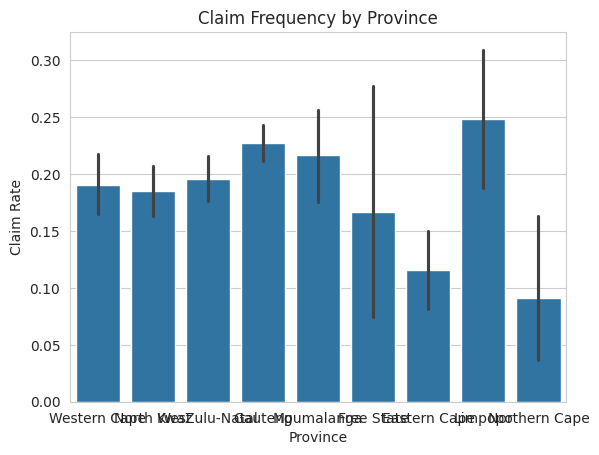

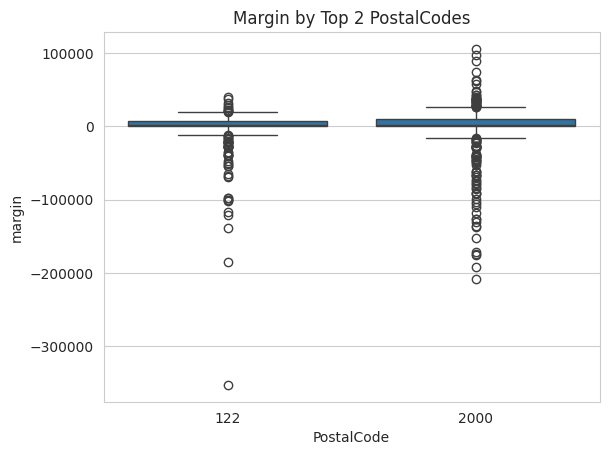

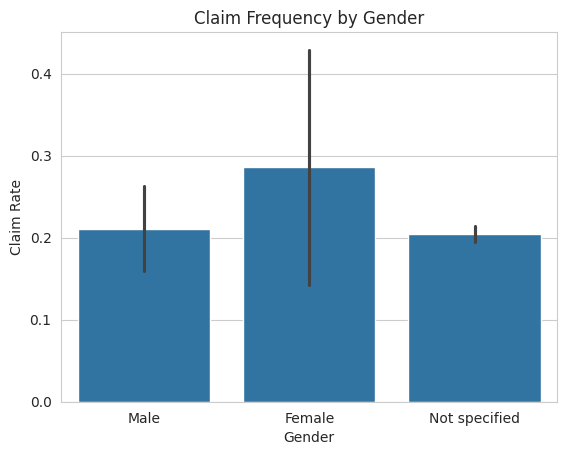

In [28]:
# Claim frequency by Province
sns.barplot(x="Province", y="has_claim", data=policy_df,
            estimator=lambda x: sum(x)/len(x))
plt.ylabel("Claim Rate")
plt.title("Claim Frequency by Province")
plt.show()

# Margin boxplot for top 2 PostalCodes
sns.boxplot(x="PostalCode", y="margin", data=policy_df[policy_df["PostalCode"].isin(top2_postal)])
plt.title("Margin by Top 2 PostalCodes")
plt.show()

# Claim frequency by Gender
sns.barplot(x="Gender", y="has_claim", data=policy_df,
            estimator=lambda x: sum(x)/len(x))
plt.ylabel("Claim Rate")
plt.title("Claim Frequency by Gender")
plt.show()


In [29]:
# Function to test each hypothesis
def test_hypotheses(df):
    results = []

    # H1: Risk difference across Provinces
    table = pd.crosstab(df["Province"], df["has_claim"])
    chi2, p, _, _ = stats.chi2_contingency(table)
    results.append({
        "Hypothesis": "Risk by Province",
        "Test": "Chi-square",
        "p_value": p,
        "Result": "Reject" if p < 0.05 else "Fail to reject",
        "Interpretation": "Some provinces have higher claim frequency; adjust premiums regionally" if p < 0.05 else "No significant difference across provinces"
    })

    # H2: Risk difference between PostalCodes (top 20 for simplicity)
    top_postal = df["PostalCode"].value_counts().nlargest(20).index
    df_pc = df[df["PostalCode"].isin(top_postal)]
    table = pd.crosstab(df_pc["PostalCode"], df_pc["has_claim"])
    chi2, p, _, _ = stats.chi2_contingency(table)
    results.append({
        "Hypothesis": "Risk by PostalCode",
        "Test": "Chi-square",
        "p_value": p,
        "Result": "Reject" if p < 0.05 else "Fail to reject",
        "Interpretation": "Claim frequency differs by postal code; consider zip-based segmentation" if p < 0.05 else "No significant difference across postal codes"
    })

    # H3: Margin difference by top 2 PostalCodes
    top2_postal = df["PostalCode"].value_counts().nlargest(2).index
    group1 = df[df["PostalCode"]==top2_postal[0]]["margin"]
    group2 = df[df["PostalCode"]==top2_postal[1]]["margin"]
    t_stat, p = stats.ttest_ind(group1, group2, equal_var=False)
    results.append({
        "Hypothesis": "Margin by PostalCode",
        "Test": "T-test",
        "p_value": p,
        "Result": "Reject" if p < 0.05 else "Fail to reject",
        "Interpretation": "Significant margin difference; adjust premiums" if p < 0.05 else "No significant difference in margin"
    })

    # H4: Risk difference by Gender
    table = pd.crosstab(df["Gender"], df["has_claim"])
    chi2, p, _, _ = stats.chi2_contingency(table)
    results.append({
        "Hypothesis": "Risk by Gender",
        "Test": "Chi-square",
        "p_value": p,
        "Result": "Reject" if p < 0.05 else "Fail to reject",
        "Interpretation": "Claim frequency differs by gender" if p < 0.05 else "No significant difference between genders"
    })

    return pd.DataFrame(results)

# Run the tests
summary = test_hypotheses(policy_df)
summary


,Hypothesis,Test,p_value,Result,Interpretation
0,Risk by Province,Chi-square,0.000019,Reject,Some provinces have higher claim frequency; ad...
1,Risk by PostalCode,Chi-square,0.000010,Reject,Claim frequency differs by postal code; consid...
2,Margin by PostalCode,T-test,0.617068,Fail to reject,No significant difference in margin
3,Risk by Gender,Chi-square,0.481507,Fail to reject,No significant difference between genders
